In [1]:
  ! pip install ftfy regex tqdm
  ! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 2.4 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-zwvngdyu
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-zwvngdyu
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=8bc39d4899ea12d0e7d62ccde0f3746a2ad7bb01e37c20a0dc33ee71384b639c
  Stored in directory: /tmp/pip-ephem-wheel-cache-dc6jivvz/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


# New dataset creation

In [8]:
import os
import csv

# Функция для проверки наличия файлов с картинками
def check_image_files(folder_path):
    image_path = os.path.join(folder_path, 'im.jpg')
    correct_path = os.path.join(folder_path, 'correct.jpg')
    
    if os.path.exists(image_path) and os.path.exists(correct_path):
        return True
    else:
        return False
    
# Путь к директории с папками
directory = 'data/benchmarked'
# Список всех папок в директории
folders = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]

# Создаем CSV-файл для записи результатов
with open('data/benchmarked/results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image 1', 'Image 2', 'Boolean'])

    # Проходим по каждой папке
    for i, folder in enumerate(folders):
        # Получаем путь к текущей папке
        folder_path = os.path.join(directory, folder)

        # Проверяем наличие файлов с картинками
        if check_image_files(folder_path):
            # Создаем строки для таблицы, если файлы существуют
            first_row = [os.path.join(folder_path, 'im.jpg'), os.path.join(folder_path, 'correct.jpg'), True]
            writer.writerow(first_row)

            next_folder = folders[i + 1] if i < len(folders) - 1 else None

            if next_folder and check_image_files(next_folder):
                next_folder_path = os.path.join(directory, next_folder)
                second_row = [os.path.join(folder_path, 'im.jpg'), os.path.join(next_folder_path, 'correct.jpg'), False]
                writer.writerow(second_row)

# Fine Tuning

In [9]:
import clip
import torch
from torch import nn

# Загрузка предварительно обученной модели CLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Заморозка весов модели CLIP
for param in model.parameters():
    param.requires_grad = False

In [10]:
import torch
import numpy as np
import clip
import torch
from torch import nn
from PIL import Image

class CLIPFineTuneModel(nn.Module):
    """
    Класс для настройки модели CLIP с добавлением линейного слоя для финетюнинга.

    Атрибуты:
    - clip_model (torch.nn.Module): предобученная модель CLIP.
    - linear (torch.nn.Linear): линейный слой для трансформации признаков.
    - cosine_similarity (torch.nn.CosineSimilarity): слой для вычисления косинусного сходства между векторами признаков.

    Методы:
    - forward(img1, img2): Проход вперед, который принимает пары изображений и возвращает оценку их сходства.
    """

    def __init__(self, clip_model):
        """
        Инициализирует класс с предобученной моделью CLIP и добавляет линейный слой.

        Параметры:
        - clip_model (torch.nn.Module): предобученная модель CLIP.
        """
        super(CLIPFineTuneModel, self).__init__()
        self.clip_model = clip_model
        self.linear = nn.Linear(512, 64)
        self.cosine_similarity = nn.CosineSimilarity(dim=1)

    def forward(self, img1, img2):
        """
        Выполняет проход вперед, принимая два изображения и вычисляя их сходство.

        Параметры:
        - img1 (torch.Tensor): тензор первого изображения.
        - img2 (torch.Tensor): тензор второго изображения.

        Выходные данные:
        - similarity (torch.Tensor): тензор с оценками сходства изображений.
        """
        with torch.no_grad():
            features1 = self.clip_model.encode_image(img1).to(dtype=torch.float32)
            features2 = self.clip_model.encode_image(img2).to(dtype=torch.float32)

        transformed_features1 = self.linear(features1).to(dtype=torch.float32)
        transformed_features2 = self.linear(features2).to(dtype=torch.float32)
        transformed_features1 = transformed_features1 / transformed_features1.norm(dim=-1, keepdim=True)
        transformed_features2 = transformed_features2 / transformed_features2.norm(dim=-1, keepdim=True)

        similarity = self.cosine_similarity(transformed_features1, transformed_features2).unsqueeze(-1).to(dtype=torch.float32)
        return similarity

In [11]:
finetune_model = CLIPFineTuneModel(model).to(device)

In [12]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

class CustomImageDataset(Dataset):
    """
    Класс датасета для пар изображений с метками их соответствия.

    Атрибуты:
    - dataframe (pandas.DataFrame): DataFrame с путями к изображениям и метками соответствия.
    - transform (callable, optional): Преобразование, применяемое к каждому изображению.
    - base_path (str): Базовый путь к изображениям.

    Методы:
    - __len__(): Возвращает размер датасета.
    - __getitem__(idx): Возвращает пару изображений и метку их соответствия по индексу.
    """

    def __init__(self, dataframe, transform=None, base_path='train_data2/benchmarked/'):
        """
        Инициализирует датасет с указанным DataFrame, трансформацией и базовым путем.

        Параметры:
        - dataframe (pandas.DataFrame): DataFrame с данными.
        - transform (callable, optional): Функция преобразования изображений. По умолчанию None.
        - base_path (str): Базовый путь к изображениям. По умолчанию 'train_data2/benchmarked/'.
        """
        self.dataframe = dataframe
        self.transform = transform
        self.base_path = base_path

    def __len__(self):
        """
        Возвращает общее количество пар изображений в датасете.

        Выходные данные:
        - int: Количество пар изображений.
        """
        return len(self.dataframe)

    def __getitem__(self, idx):
        """
        Возвращает пару изображений и метку их соответствия по указанному индексу.

        Параметры:
        - idx (int): Индекс пары изображений в датасете.

        Выходные данные:
        - tuple: Пара трансформированных изображений и метка соответствия (torch.Tensor, torch.Tensor, float).
        """
        img1_path = self.base_path + self.dataframe.iloc[idx, 0]
        img2_path = self.base_path + self.dataframe.iloc[idx, 1]
        label = self.dataframe.iloc[idx, 2].astype(np.float32)

        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")

        if self.transform:
            img1 = self.transform(img1)
            img1 = (img1 - torch.min(img1)) / (torch.max(img1) - torch.min(img1))
            img2 = self.transform(img2)
            img2 = (img2 - torch.min(img2)) / (torch.max(img2) - torch.min(img2))

        return img1, img2, label


dataframe = pd.read_csv('data/benchmarked/results.csv')
dataset = CustomImageDataset(dataframe=dataframe.head(256), transform=preprocess, base_path='')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [13]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def show_batch(dataloader):
    """
    Отображает первый батч изображений из даталоудера.

    Параметры:
    - dataloader (DataLoader): загрузчик данных PyTorch, содержащий пары изображений и метки их соответствия.

    Выходные данные:
    - None. Функция отображает изображения из первого батча в dataloader, используя matplotlib.
    """
    for img1, img2, labels in dataloader:
        batch_size = img1.size(0)  # Получаем размер батча
        if batch_size == 1:
            fig, axs = plt.subplots(batch_size, 2, figsize=(10, 5 * batch_size))
            axs = np.array([axs])  # Преобразуем axs в 2D массив для унификации доступа
        else:
            fig, axs = plt.subplots(batch_size, 2, figsize=(10, 5 * batch_size))

        for i in range(batch_size):
            image1_pil = F.to_pil_image(img1[i].squeeze().cpu())
            image2_pil = F.to_pil_image(img2[i].squeeze().cpu())

            if batch_size == 1:
                ax1, ax2 = axs[0]  # Для одномерного случая
            else:
                ax1, ax2 = axs[i]  # Для многомерного случая

            ax1.imshow(image1_pil)
            ax1.set_title("Image 1")
            ax1.axis('off')

            ax2.imshow(image2_pil)
            ax2.set_title(f"Image 2 - {'True' if labels[i].item() == 1.0 else 'False'}")
            ax2.axis('off')

        plt.tight_layout()
        plt.show()
        break  # Отображаем только первый батч

In [ ]:
show_batch(dataloader)

Epoch 1, Training Loss: 0.0015384334630133317, Validation Loss: 0.00015935707657869594
Epoch 2, Training Loss: 0.00010262169841250095, Validation Loss: 6.403548043939129e-05


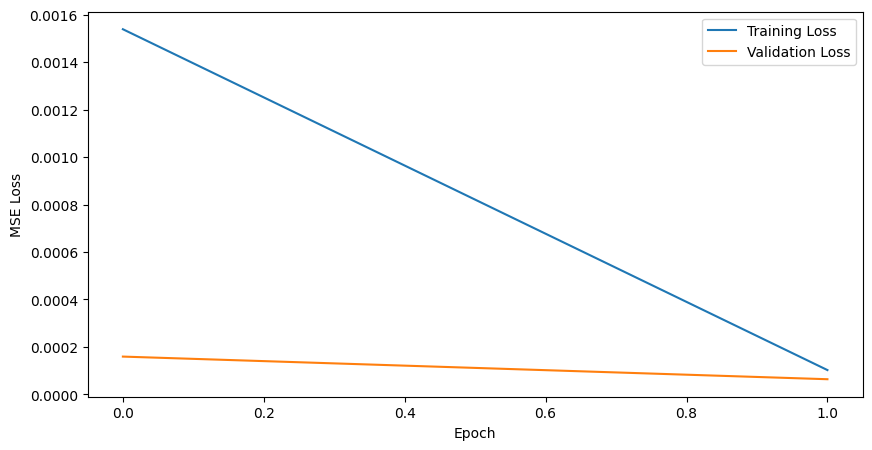

In [15]:
import clip
import torch
from torch import nn, optim
from torch.optim import Adam
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


dataframe = pd.read_csv('data/benchmarked/results.csv')

# Коэффициент для определения индекса разделения данных (исключая последние 10%)
split_ratio = 0.9
train_ratio = 0.8

# Вычисляем индекс для разделения данных, чтобы исключить последние 10%
split_index = int(len(dataframe) * split_ratio)

# Разделяем набор данных, чтобы исключить последние 10%
dataframe = dataframe[:split_index]

# Инициализируем набор данных с изменённым датафреймом
dataset = CustomImageDataset(dataframe=dataframe, transform=preprocess, base_path='')

# Разделяем набор данных на тренировочный и валидационный наборы
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Загрузчики данных для тренировочного и валидационного наборов
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def train_and_validate(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=10):
    """
    Обучает и валидирует модель на данных из даталоудеров.

    Параметры:
    - model (torch.nn.Module): модель для обучения.
    - train_dataloader (DataLoader): загрузчик данных для обучения.
    - test_dataloader (DataLoader): загрузчик данных для валидации.
    - criterion (torch.nn.modules.loss): функция потерь.
    - optimizer (torch.optim.Optimizer): оптимизатор.
    - num_epochs (int, optional): количество эпох обучения. По умолчанию 10.

    Выходные данные:
    - None. Функция обучает модель, отображает график потерь на обучающем и валидационном наборах данных.
    """
    model.train()
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for img1, img2, labels in train_dataloader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(img1, img2)
            loss = criterion(outputs, labels.view(-1, 1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_dataloader))

        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for img1, img2, labels in test_dataloader:
                img1, img2, labels = img1.to(device), img2.to(device), labels.to(device).float()
                outputs = model(img1, img2)
                loss = criterion(outputs, labels.view(-1, 1))
                total_test_loss += loss.item()
        test_losses.append(total_test_loss / len(test_dataloader))

        print(f"Epoch {epoch+1}, Training Loss: {train_losses[-1]}, Validation Loss: {test_losses[-1]}")

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

optimizer = Adam(finetune_model.linear.parameters(), lr=1e-2)
criterion = nn.MSELoss()

train_and_validate(finetune_model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=2)

In [10]:
os.listdir('data/benchmarked\\186121\\')

[]

In [ ]:
def calculate_accuracy(model, dataloader, threshold=0.6):
    """
    Вычисляет точность модели на данных из даталоадера.

    Параметры:
    - model (torch.nn.Module): модель для оценки.
    - dataloader (DataLoader): загрузчик данных для оценки.
    - threshold (float, optional): порог для классификации между классами. По умолчанию 0.6.

    Выходные данные:
    - accuracy (float): точность модели на предоставленном наборе данных.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for img1, img2, labels in dataloader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            outputs = model(img1, img2)
            predictions = outputs > threshold
            correct += (predictions.flatten().int() == labels.int()).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    return accuracy


# Вычисляем accuracy на тестовом наборе данных
test_accuracy = calculate_accuracy(finetune_model, test_dataloader, threshold=0.7)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.7734138972809668


In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
import torch
from torch.utils.data import DataLoader

def get_model_predictions_and_labels(model: torch.nn.Module, dataloader: DataLoader, device: torch.device) -> tuple:
    """
    Функция для получения предсказаний модели и истинных меток из даталоадера.

    Аргументы:
    - model: torch.nn.Module - модель для оценки
    - dataloader: DataLoader - загрузчик данных
    - device: torch.device - устройство, на котором происходит вычисление

    Возвращает кортеж:
    - predictions: List[float] - предсказания модели
    - labels_list: List[int] - истинные метки
    """
    model.eval()
    predictions = []
    labels_list = []

    with torch.no_grad():
        for img1, img2, labels in dataloader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            outputs = model(img1, img2)
            predictions.extend(outputs.flatten().cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

    return predictions, labels_list

def plot_roc_curve(model: torch.nn.Module, dataloader: DataLoader, device: torch.device):
    """
    Функция для построения ROC-кривой для модели на данных из даталоадера.

    Аргументы:
    - model: torch.nn.Module - модель для оценки
    - dataloader: DataLoader - загрузчик данных
    - device: torch.device - устройство, на котором происходит вычисление
    """
    predictions, labels = get_model_predictions_and_labels(model, dataloader, device)
    fpr, tpr, thresholds = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Кривая ROC (Receiver Operating Characteristic)')
    plt.legend(loc="lower right")
    plt.show()
plot_roc_curve(finetune_model, test_dataloader, device)

ModuleNotFoundError: No module named 'sklearn'

In [21]:
# Путь для сохранения модели
model_path = 'drive/MyDrive/Data_Science/other/capcha/finetuned_clip_model_delme.pth'
optimizer_path = 'drive/MyDrive/Data_Science/other/capcha/optimizer_state_delme.pth'

# Сохранение модели
torch.save(finetune_model.state_dict(), model_path)

# Сохранение состояния оптимизатора (по желанию)
torch.save(optimizer.state_dict(), optimizer_path)

# New dataset creation

In [ ]:
import zipfile
import os

zip_filename = 'drive/MyDrive/Data_Science/other/capcha/benchmarked.zip'
extract_folder = 'train_data2'

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print('Архив успешно разархивирован в указанную папку!')

Архив успешно разархивирован в указанную папку!


In [ ]:
import os
import csv

# Путь к директории с папками
directory = 'train_data2/benchmarked'
# Список всех папок в директории
folders = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]

# Создаем CSV-файл для записи результатов
with open('train_data2/benchmarked/results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image 1', 'Image 2', 'Boolean'])

    # Проходим по каждой папке
    for i, folder in enumerate(folders):
        # Получаем путь к текущей папке
        folder_path = os.path.join(directory, folder)

        # Смотрим, есть ли следующая папка
        next_folder = folders[i + 1] if i < len(folders) - 1 else None

        # Создаем строки для таблицы, если это возможно
        first_row = [os.path.join(folder_path, 'im.jpg'), os.path.join(folder_path, 'correct.jpg'), True]
        writer.writerow(first_row)

        if next_folder:
            next_folder_path = os.path.join(directory, next_folder)
            second_row = [os.path.join(folder_path, 'im.jpg'), os.path.join(next_folder_path, 'correct.jpg'), False]
            writer.writerow(second_row)

# Inference

In [ ]:
import clip
import torch
from torch import nn
from PIL import Image

# Загрузка предварительно обученной модели CLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Инициализация модели надстройки
finetune_model = CLIPFineTuneModel(model).to(device)

# Путь к сохраненной модели
model_path = 'finetuned_clip_model.pth'

# Загрузка весов в модель
finetune_model.load_state_dict(torch.load(model_path))
finetune_model.eval()  # Переключение модели в режим оценки

# Загрузка изображений
img1_path = '183103_icon_1.jpg'
img2_path = '183103_icon_2.jpg'
img1 = Image.open(img1_path).convert("RGB")
img2 = Image.open(img2_path).convert("RGB")

# Преобразование изображений
img1_processed = preprocess(img1).unsqueeze(0).to(device)
img2_processed = preprocess(img2).unsqueeze(0).to(device)

# Применение модели
with torch.no_grad():
    similarity = finetune_model(img1_processed, img2_processed)
    print(f"Similarity: {similarity.item()}")

Similarity: 0.6541217565536499


In [ ]:
2+2

4

# Inference test

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.6 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-37ls9nht
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-37ls9nht
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=78f87b7185107db6d411c0958958714b53aff747aa23ae353ff16d5e8e91d0f6
  Stored in directory: /tmp/pip-ephem-wheel-cache-399p3kxw/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
!gdown --id 17UeoS3l5IEr7uCmLsjxjqxWpMnUEoWwQ

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=17UeoS3l5IEr7uCmLsjxjqxWpMnUEoWwQ
From (redirected): https://drive.google.com/uc?id=17UeoS3l5IEr7uCmLsjxjqxWpMnUEoWwQ&confirm=t&uuid=e1888beb-db79-42c9-bd36-82bdf74adfb9
To: /content/finetuned_clip_model_roc093.pth
100% 354M/354M [00:05<00:00, 62.8MB/s]


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
# Инициализация модели надстройки
finetune_model = CLIPFineTuneModel(model).to(device)

# Путь к сохраненной модели
model_path = 'finetuned_clip_model_roc093.pth'

# Загрузка весов в модель
#finetune_model.load_state_dict(torch.load(model_path))
finetune_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
finetune_model.eval()  # Переключение модели в режим оценки

TypeError: CLIPFineTuneModel.__init__() takes 1 positional argument but 2 were given

In [3]:
import os
import torch
from PIL import Image
import clip
from torch import nn

# Загрузка модели CLIP и предобработка изображений
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)


class CLIPFineTuneModel(nn.Module):
    def init(self, clip_model):
        super(CLIPFineTuneModel, self).init()
        self.clip_model = clip_model
        self.linear = nn.Linear(512, 64)  # Предполагается, что размерность вектора признаков CLIP - 512
        self.cosine_similarity = nn.CosineSimilarity(dim=1)

    def forward(self, img1, img2):
        with torch.no_grad():
            features1 = self.clip_model.encode_image(img1).to(dtype=torch.float32)
            features2 = self.clip_model.encode_image(img2).to(dtype=torch.float32)

        transformed_features1 = self.linear(features1).to(dtype=torch.float32)
        transformed_features2 = self.linear(features2).to(dtype=torch.float32)
        transformed_features1 = transformed_features1 / transformed_features1.norm(dim=-1, keepdim=True)
        transformed_features2 = transformed_features2 / transformed_features2.norm(dim=-1, keepdim=True)

        similarity = self.cosine_similarity(transformed_features1, transformed_features2).unsqueeze(-1).to(dtype=torch.float32)

        return similarity


# Инициализация и загрузка весов модели надстройки
finetune_model = CLIPFineTuneModel(clip_model).to(device)
model_path = 'finetuned_clip_model_roc093.pth'
finetune_model.load_state_dict(torch.load(model_path, map_location=device))
finetune_model.eval()

def get_image_features(image_path, model, preprocess):
    image = Image.open(image_path).convert("RGB")
    image_processed = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model.encode_image(image_processed).to(dtype=torch.float32)
    return features, image

def compare_images(base_image_folder, compare_image_folder, digit, finetune_model, preprocess, visualize=False):
    base_image_path = os.path.join(base_image_folder, "im.jpg")
    base_features, base_image = get_image_features(base_image_path, clip_model, preprocess)

    max_similarity = -1
    max_similarity_index = -1

    for i in range(1, 6):
        compare_image_path = os.path.join(compare_image_folder, f"x_{i}", f"{digit}.jpg")
        try:
            compare_features, compare_image = get_image_features(compare_image_path, clip_model, preprocess)
            # Использование модели надстройки для сравнения
            similarity = finetune_model(base_features, compare_features).cpu().numpy()
            if similarity > max_similarity:
                max_similarity = similarity
                max_similarity_index = i
            if visualize:
                # Функция display_comparison не определена в данном примере
                display_comparison(base_image, compare_image, similarity, i)
        except FileNotFoundError:
            print(f"Файл {compare_image_path} не найден.")

    return max_similarity_index


100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 55.8MiB/s]


TypeError: CLIPFineTuneModel.__init__() takes 1 positional argument but 2 were given

In [ ]:

# Пример вызова функции compare_images
base_image_folder = '/path/to/base/image/folder'
compare_image_folder = '/path/to/compare/image/folder'
digit = '1'  # Пример цифры
max_similarity_index = compare_images(base_image_folder, compare_image_folder, digit, finetune_model, preprocess, visualize=True)
print(f"Наибольшая схожесть в папке: x_{max_similarity_index}")